<h1 align=center>CS 340</h1>
<h1 align=center>Computer Systems</h1>
<img src="https://preview.ibb.co/cEO66Q/intro.png" align=center>

<h2 align=center>Lorem Ipsum</h2>

<h2>What is this project about?</h2>
<p>
    It uses Twitter's API to stream tweets about one or more <br>
    hashtag and classify the tweets as positively or negatively <br>
    inclined to give an idea on what people think about the <br>
    topic without having to read hundreds of tweets. <br>
</p>

<h2>Which means?</h2>
<p>
    User enters the hashtags that he wants to know more about. <br><br>
    $hashtags = [ "\#spark", "\#IBM" ]$
</p><br>
<p>
    And the following code shows people's thoughts about the topic. <br><br>
    $result = main( hashtags )$ <br>
    $result.show()$
</p><br>
<p>
    <img align=left src=https://image.ibb.co/eqY3Lk/ibm_spark_result.png>
</p><br><br><br><br><br>
<p>
    But of course, <br>
    There is a better way of showing these results.<br>
</p>

<h3>Initialization</h3>

In [ ]:
# The code was removed by DSX for sharing.
path_1 = "scores_dictionary.txt"
path_2 = "test_data.txt"
path_3 = "#DonaldTrump.json"

In [1]:
def assign_value(word):
    try:
        return my_dict_bc.value[word] 
    except:
        return 0.0

def result_converter(pred):
    return "Negatively Inclined" if pred == 0.0 else "Positively Inclined"

def file_exist(filename):
    try:
        rdd = sc.textFile("swift://LoremIpsum.keystone/" + filename + ".json")
        rdd.take(1)
        return True
    except Py4JJavaError as e:
        return False

Pixiedust database opened successfully


Requirement already up-to-date: pixiedust in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s2db-321579fd8330fd-e4e6c9e7b1c6/.local/lib/python2.7/site-packages
Requirement already up-to-date: lxml in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s2db-321579fd8330fd-e4e6c9e7b1c6/.local/lib/python2.7/site-packages (from pixiedust)
Requirement already up-to-date: mpld3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s2db-321579fd8330fd-e4e6c9e7b1c6/.local/lib/python2.7/site-packages (from pixiedust)
  Cloning https://github.com/tweepy/tweepy to /gpfs/global_fs01/sym_shared/YPProdSpark/user/s2db-321579fd8330fd-e4e6c9e7b1c6/notebook/tmp/pip-fy_V6L-build


<div>
    <h1>How does it work?</h1>
    <h2>1- The model</h2>
    <img align=left src="http://images.easyfreeclipart.com/381/pipes-clipart-381678.jpg">
    <br><br><br><br><br><br><br><br>
    <p>
        We create a model using Logistic Regression in a Pipeline. <br><br>
        The data that is used to train the Pipeline model consists of many tweets and their assigned <br>
        positive or negative scores. <br>
    </p>
    <img align=left src="https://image.ibb.co/hAE7D5/train_data.png">
    <br><br><br><br><br><br><br><br><br><br><br><br>
    <p>
        Label 1 means positive and 0 means negative.
    </p>
</div>

<h3>Preparing the training data</h3>

In [3]:
# Preparing training data

total = ""
# Reads training data
test_file = sc.textFile(path_2)

for line in test_file.collect():
    total += line

test_data = filter(lambda x: len(x) > 5, total.split("_______"))

score_file = sc.textFile(path_1)
words_score_tuple = score_file.map(lambda x: (str(tuple(x.split())[0]), float(tuple(x.split())[1])))
word_dict = words_score_tuple.collectAsMap()

score_file = sc.textFile(path_1)
words_score_tuple = score_file.map(lambda x: (str(tuple(x.split())[0]), float(tuple(x.split())[1])))
word_dict = words_score_tuple.collectAsMap()

tweets_rdd = sc.parallelize(test_data)

zipped_rdd = tweets_rdd.zipWithUniqueId()
parsed_rdd = zipped_rdd.map(lambda (x,y): (re.split("\W+",x),y)) 

my_dict_bc = sc.broadcast(word_dict)

ids_with_tweet_scores = parsed_rdd.flatMap(lambda (whole, index): [(word, index) for word in whole])\
                                    .map(lambda (x,y): (x, (y, assign_value(x))))\
                                    .map(lambda (x,y): (y[0], y[1]) if y[1] != 0 else ()).filter(lambda x: x != ())\
                                    .groupByKey().map(lambda (x,y): (x, sum(y) / len(y)))\
                                    .persist()

tweets_with_ids = zipped_rdd.map(lambda (x,y): (y,x))

final_form = ids_with_tweet_scores.join(tweets_with_ids).map(lambda (x,y): (y[1], y[0]))\
                                    .map(lambda (x,y): (x, 0 if y <= 0 else 1))\
                                    .zipWithIndex()\
                                    .persist()

final_form = final_form.map(lambda x: Row(id=x[1], text=x[0][0], label=x[0][1]))\
                        .persist()

train_data = sqlContext.createDataFrame(final_form)\
                        .persist()



<h3>Creating the model</h3>
<p>
    Pipeline has four stages while creating the model. <br>

<li>Tokenizer</li>
<li>Stop Words Remover</li>
<li>HashingTF</li>
<li>Logistic Regression</li>

</p>

In [4]:
# Create Model
mIter = 10
rParam = 0.01

tokenizer = Tokenizer( inputCol = "text", outputCol = "words" )
remover = StopWordsRemover( inputCol = tokenizer.getOutputCol(), outputCol = "filtered")
hasher = HashingTF( inputCol = remover.getOutputCol(), outputCol="features")
lr = LogisticRegression( maxIter = mIter , regParam = rParam )

stg = [tokenizer, remover, hasher, lr]
pipeline = Pipeline( stages = stg )

model = pipeline.fit(train_data)

<h2>2- Streaming tweets</h2>
<p><img align=left src="https://pbs.twimg.com/profile_images/2284174872/7df3h38zabcvjylnyfe3.png" width=100 height=100></p>
<br><br><br><br><br>
<p>
    Twitter's API makes it easy to stream tweets into DSX. <br>
    The API returns a number of tweets which include a specific hashtag <br>
    Then we process and store the data for later retrieval. <br>
</p>

In [15]:
# Stream tweets
def stream_tweet(hashtag):
    consumer_key = '7Sh3RYqhjTFcpPqM6vWFAC0LW'
    consumer_secret = 'g5eOGWEU23kDBU5NAMqdCKdcYvDFAhRIPDCrdWSs2YFKaJWpSK'
    access_token = '810068665248915456-JG5WDZayYcQEmRrDvE0irHksQwQZy7U'
    access_secret = 'qszl5wXW25ayJBG6z6G2ngUUVRrlaLNNNEABFaAeKFXc3'

    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)

    api = tweepy.API(auth)

    tweets = []

    statuses = tweepy.Cursor(api.search, q=hashtag, rpp=100, show_user=False, lang="en").items(200)
    tweets = [s.text.encode("utf8") for s in statuses] 
    
    #tweets = sc.parallelize(tweets)
    #tweets.saveAsTextFile("swift://LoremIpsum." + name + "/" + hashtag + ".json")
    
    tweet_save = "_______".join(tweets)
    tweet_save = sc.parallelize(tweet_save)
    tweet_save.saveAsTextFile("swift://LoremIpsum." + name + "/" + hashtag + ".json")

<h2>3- Predicting tweets</h2>
<p>
    The tweets are fed into the function <i>predict_result</i>, <br>
    which returns the positive and negative number of tweets. <br>
    <br>
    Then these results are unified inside a Dataframe to be visualized later <br>
</p>

<h3>Predicting the inclination</h3>

In [5]:
def predict_result(hashtag):
    total = ""
    test_file = sc.textFile("swift://LoremIpsum.keystone/" + hashtag + ".json")

    for line in test_file.collect():
        total += line

    test_data = sc.parallelize(filter(lambda x: len(x) > 5, total.split("_______")))\
                    .zipWithIndex()\
                    .map(lambda x: Row(text=x[0], id=x[1]))\
                    .toDF()\
                    .persist()
                    
    prediction = model.transform(test_data)
    prediction = prediction.select("id", "text", "prediction")
    
    udfunc = udf(result_converter)
    final = prediction.withColumn("result", udfunc("prediction"))
    
    return final

<h3>Main function</h3>
<p>
    This function gathers everything together. <br>
    <br>
    Simply pass hashtags into this function and it will return the predictions <br>
    for each one of them in a different row <br>
</p>

In [21]:
def main(hashtags):
    all_results = list()
    errors = list()
    tweets = dict()
    
    for hashtag in hashtags:
        if not file_exist(hashtag):
            try:
                stream_tweet(hashtag)
            except:
                errors.append(hashtag)
                continue
                
        result = predict_result(hashtag)
        tweets[hashtag] = result
        
        pos = result.filter(result["result"] == "Positively Inclined").count()
        neg = result.count() - pos
        
        all_results.append(Row(Hashtag=hashtag, Positive=pos, Negative=neg))
    
    all_results = sqlContext.createDataFrame(all_results)
        
    return all_results, tweets, errors
        

<h1>Try out</h1>

In [16]:
hashtags = [
    "#IBM",
    "#spark",
] 

result, tweets, errors = main(hashtags) 

if errors: print "Couldn't retrieve: ", ", ".join(errors)

<h2>Visualization</h2>
<p>
    We are using Pixiedust to visualize the data. <br>
</p>


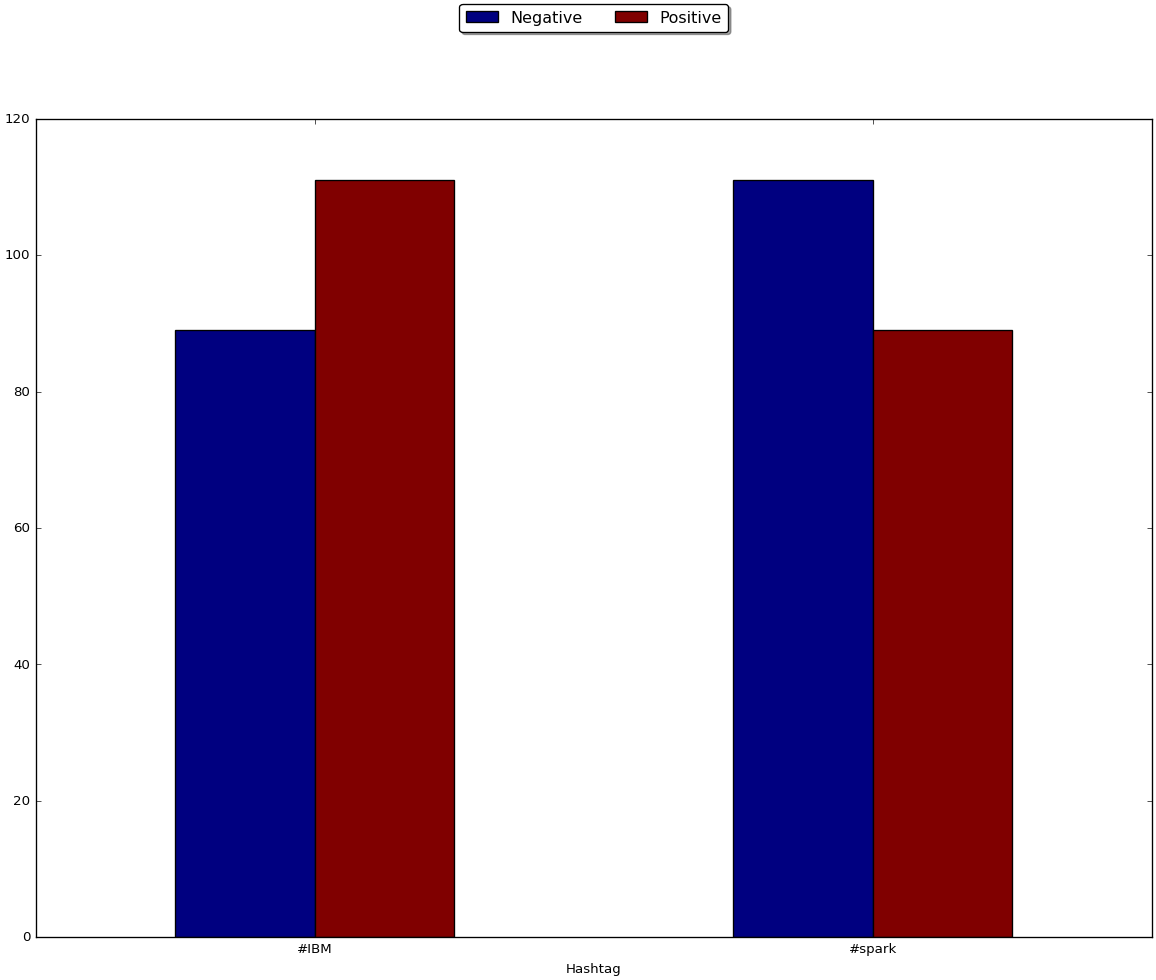

In [17]:
display(result) 

<h2>To see what people talk about by yourself</h2>
<p>
    Also if you want to see if this thing works <br>
</p>

In [20]:
display(tweets[hashtags[1]])

id,text,prediction,result
0,"RT @AtishiSapru: Who dunnit... #Spark, can you help?! https://t.co/OQgaMRLc8e https://t.co/OjMocBe6Yb",0.0,Negatively Inclined
1,"RT @FSU_Softball: The Seminoles finish 2017 unconquered in ACC play, going 24-0, after a 6-2 win over North Carolina! #SPARK https://t.co���",1.0,Positively Inclined
2,RT @FSU_Softball: BALLGAME! The Seminoles complete their perfect ACC season (24-0) with a 6-2 win over UNC! #SPARK,0.0,Negatively Inclined
3,"RT @FSU_Softball: The Seminoles finish 2017 unconquered in ACC play, going 24-0, after a 6-2 win over North Carolina! #SPARK https://t.co���",1.0,Positively Inclined
4,RT @FSU_Softball: BALLGAME! The Seminoles complete their perfect ACC season (24-0) with a 6-2 win over UNC! #SPARK,0.0,Negatively Inclined
5,RT @ImDataScientist: Survey Sees #Spark Emerging in 2016 https://t.co/Z6ZkMpJclk #analytics #datascience @mapr #bigdata #Hadoop #IoT #datab���,0.0,Negatively Inclined
6,RT @FSU_Softball: SEE YA! Jessica Warren ties the game at 1-1 and sets an FSU record with a solo home run to left! #SPARK https://t.co/bKQ���,0.0,Negatively Inclined
7,RT @fernandocuenca: GoDaddy's #BigData #Analytics#Tableau #Hadoop Hive #Microsoft #SQLServer #MySQL #Spark��#Cassandrahttps://t.co/twmkyY7���,0.0,Negatively Inclined
8,"RT @FSU_Softball: The Seminoles finish 2017 unconquered in ACC play, going 24-0, after a 6-2 win over North Carolina! #SPARK https://t.co���",1.0,Positively Inclined
9,RT @DBaker007: The Lord of the Things: #Spark or #Hadoop? | @KirkDBorne @mapr https://t.co/RRLV95ptKm #IoT #BigData #ML https://t.co/RydrgO���,0.0,Negatively Inclined


<h1 align=center>Thank you!</h1>